<a href="https://colab.research.google.com/github/AmiraliLalehpour/MMAI869-Pump-it-Up-Competition/blob/main/PIU_Model_Fitting_With_CrossValidation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#MMAI 869, Smith School of Business at Queens University
###Team Broadview Project, Pump it Up: Data Mining the Water Table

#Install and ImportRequired Libraries

In [605]:
pip install feature_engine

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [606]:
pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


###Import Libraries

In [607]:
import sys
import numpy as np  
import pandas as pd  
import datetime as dt

# from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from collections import Counter
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier

from prettytable import PrettyTable
from sklearn.metrics import accuracy_score, log_loss, f1_score, precision_score, recall_score, plot_roc_curve
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report


from sklearn.metrics import r2_score, mean_squared_error, explained_variance_score, mean_squared_error, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, RepeatedStratifiedKFold, cross_val_score, StratifiedKFold, cross_val_predict
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder
from sklearn.utils import compute_class_weight
from sklearn.metrics import plot_roc_curve
from sklearn import metrics

from feature_engine.encoding import RareLabelEncoder

from category_encoders import *
from category_encoders.wrapper import PolynomialWrapper
# from category_encoders import OneHotEncoder, TargetEncoder, JamesSteinEncoder, CatBoostEncoder, MEstimateEncoder, WOEEncoder, LeaveOneOutEncoder

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns


### Check Allocated System Specs by Google Colab

In [608]:
from psutil import *

cpu_count()

2

In [609]:
!lscpu |grep 'Model name'

Model name:          Intel(R) Xeon(R) CPU @ 2.20GHz


In [610]:
!df -h / |awk '{print $4}'

Avail
85G


In [611]:
!free -h  --si | awk '/Mem:/{print $2}'

13G


In [612]:
!nvidia-smi -L

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [613]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



#1. Loading the dataset from GitHub: [MMAI869-Pump-it-Up-Competition]

  Data is accessed from github: (https://github.com/AmiraliLalehpour/MMAI869-Pump-it-Up-Competition)



In [614]:
train_ulr = 'https://raw.githubusercontent.com/AmiraliLalehpour/MMAI869-Pump-it-Up-Competition/main/preprocessed_data.csv'
test_ulr = 'https://raw.githubusercontent.com/AmiraliLalehpour/MMAI869-Pump-it-Up-Competition/main/preprocessed_test.csv'
tt_ulr = 'https://raw.githubusercontent.com/AmiraliLalehpour/MMAI869-Pump-it-Up-Competition/main/clean.csv'
# ulr_Test_Set_Values = 'https://raw.githubusercontent.com/AmiraliLalehpour/MMAI869-Pump-it-Up-Competition/main/Test_Set_Values.csv'
data = pd.read_csv(train_ulr)
test = pd.read_csv(test_ulr)
train2 = pd.read_csv(tt_ulr)
# test = pd.read_csv(ulr_Test_Set_Values)
# data = Training_Set_Values.merge(Training_Set_Labels, on='id', how='right')

pd.set_option('display.max_columns', None)

In [615]:
test_id = test.id

In [616]:
data.head()

,id,amount_tsh,funder,gps_height,longitude,latitude,basin,region,district_code,lga,ward,population,public_meeting,scheme_management,permit,construction_year,extraction_type,management,payment_type,water_quality,quantity,source,waterpoint_type,status_group,year_recorded,month_recorded,day_recorded,quarer_recorded,percipitation_class,well_age
0,69572,6000.0,Roman,1390.000000,34.938093,-9.856322,Lake Nyasa,Iringa,5,Ludewa,Mundindi,109.0,Yes,VWC,No,1999.0,gravity,vwc,annually,soft,enough,spring,communal standpipe,functional,2011,3,0,1,4,12.0
1,8776,200.0,Grumeti,1399.000000,34.698766,-2.147466,Lake Victoria,Mara,2,Serengeti,Natta,280.0,Missing,Other,Yes,2010.0,gravity,wug,never pay,soft,insufficient,rainwater harvesting,communal standpipe,functional,2013,3,2,1,4,3.0
2,34310,25.0,Lottery Club,686.000000,37.460664,-3.821329,Pangani,Manyara,4,Simanjiro,Ngorika,250.0,Yes,VWC,Yes,2009.0,gravity,vwc,per bucket,soft,enough,dam,communal standpipe multiple,functional,2013,2,0,1,2,4.0
3,67743,50.0,Unicef,263.000000,38.486161,-11.155298,Ruvuma / Southern Coast,Mtwara,63,Nanyumbu,Nanyumbu,58.0,Yes,VWC,Yes,1986.0,submersible,vwc,never pay,soft,dry,machine dbh,communal standpipe multiple,non functional,2013,1,0,1,4,27.0
4,19728,250.0,Action In A,1057.545585,31.130847,-1.825359,Lake Victoria,Kagera,1,Karagwe,Nyakasimbi,200.0,Yes,Missing,Yes,2003.0,gravity,other,never pay,soft,seasonal,rainwater harvesting,communal standpipe,functional,2011,7,2,3,0,8.0


In [617]:
#turn out the public_meeting has zero variance with target so we will drop it
data.drop(['public_meeting'],axis=1, inplace=True)
test.drop(['public_meeting'],axis=1, inplace=True)

data.drop(['permit'],axis=1, inplace=True)
test.drop(['permit'],axis=1, inplace=True)

In [618]:
data.head()

,id,amount_tsh,funder,gps_height,longitude,latitude,basin,region,district_code,lga,ward,population,scheme_management,construction_year,extraction_type,management,payment_type,water_quality,quantity,source,waterpoint_type,status_group,year_recorded,month_recorded,day_recorded,quarer_recorded,percipitation_class,well_age
0,69572,6000.0,Roman,1390.000000,34.938093,-9.856322,Lake Nyasa,Iringa,5,Ludewa,Mundindi,109.0,VWC,1999.0,gravity,vwc,annually,soft,enough,spring,communal standpipe,functional,2011,3,0,1,4,12.0
1,8776,200.0,Grumeti,1399.000000,34.698766,-2.147466,Lake Victoria,Mara,2,Serengeti,Natta,280.0,Other,2010.0,gravity,wug,never pay,soft,insufficient,rainwater harvesting,communal standpipe,functional,2013,3,2,1,4,3.0
2,34310,25.0,Lottery Club,686.000000,37.460664,-3.821329,Pangani,Manyara,4,Simanjiro,Ngorika,250.0,VWC,2009.0,gravity,vwc,per bucket,soft,enough,dam,communal standpipe multiple,functional,2013,2,0,1,2,4.0
3,67743,50.0,Unicef,263.000000,38.486161,-11.155298,Ruvuma / Southern Coast,Mtwara,63,Nanyumbu,Nanyumbu,58.0,VWC,1986.0,submersible,vwc,never pay,soft,dry,machine dbh,communal standpipe multiple,non functional,2013,1,0,1,4,27.0
4,19728,250.0,Action In A,1057.545585,31.130847,-1.825359,Lake Victoria,Kagera,1,Karagwe,Nyakasimbi,200.0,Missing,2003.0,gravity,other,never pay,soft,seasonal,rainwater harvesting,communal standpipe,functional,2011,7,2,3,0,8.0


#2. Label Distribution and Label Encoding
Multiclass Classification Labels, need to encode them

Reference: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html

Text(0, 0.5, 'Number of Occurance')

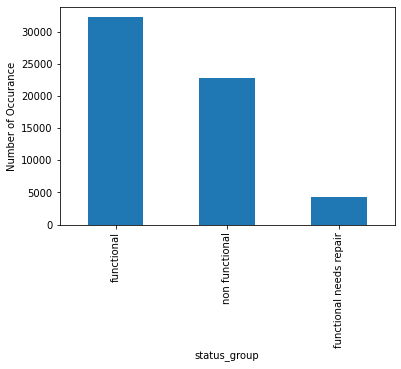

In [619]:
data.status_group.value_counts().plot.bar()
plt.xlabel('status_group')
plt.ylabel('Number of Occurance')

In [620]:
data.status_group.value_counts()


functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

In [621]:
data.status_group.value_counts(normalize=True)

functional                 0.543081
non functional             0.384242
functional needs repair    0.072677
Name: status_group, dtype: float64

In [622]:
label_encouder=LabelEncoder()
data.status_group = label_encouder.fit_transform(data.status_group)
data.status_group.head()

0    0
1    0
2    0
3    2
4    0
Name: status_group, dtype: int64

Text(0, 0.5, 'Number of Occurance')

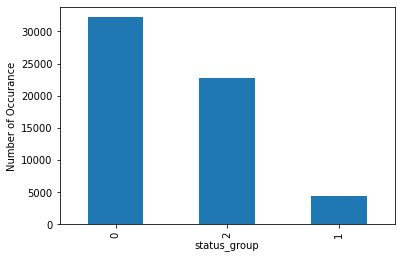

In [623]:
data.status_group.value_counts().plot.bar()
plt.xlabel('status_group')
plt.ylabel('Number of Occurance')

#3. Defining the Encoders for Use in Cross Validation

##3.1. Rare Value Encoders

In [624]:
data.select_dtypes(include='object').columns

Index(['funder', 'basin', 'region', 'lga', 'ward', 'scheme_management',
       'extraction_type', 'management', 'payment_type', 'water_quality',
       'quantity', 'source', 'waterpoint_type'],
      dtype='object')

In [625]:
rare_encoder = RareLabelEncoder(
  tol=0.025,  # minimal percentage to be considered non-rare
  n_categories=4, # minimal number of categories the variable should have to re-cgroup rare categories
  variables=['scheme_management', 'extraction_type', 'management', 'water_quality', 'source','waterpoint_type'], # variables to re-group
  replace_with='Rare')

rare_encoder_EXtreme_Cardinality = RareLabelEncoder(
  tol=0.007,  # minimal percentage to be considered non-rare
  n_categories=4, # minimal number of categories the variable should have to re-cgroup rare categories
  max_n_categories = 50,
  # variables=['lga', 'funder'], # variables to re-group
  variables=['funder'], # variables to re-group
  replace_with='Rare')

rare_encoder_ExCard_ward = RareLabelEncoder(
  tol=0.002,  # minimal percentage to be considered non-rare
  n_categories=4, # minimal number of categories the variable should have to re-cgroup rare categories
  max_n_categories = 500,
  variables=['ward'], # variables to re-group
  replace_with='Rare')


##3.2. Categorical Encoders
https://www.kaggle.com/code/subinium/11-categorical-encoders-and-benchmark

https://contrib.scikit-learn.org/category_encoders/

https://towardsdatascience.com/target-encoding-for-multi-class-classification-c9a7bcb1a53



###3.2.1. Target Encoder

In [626]:
tar_train=data.copy()
tar_test=test.copy()

In [627]:
tar_train.drop(['id'],axis=1, inplace=True)
tar_test.drop(['id'],axis=1, inplace=True)

In [628]:
# X = tar_train.drop('status_group', axis=1)

In [629]:
# y = tar_train.status_group
# y=np.array(y)
# y=y.astype(int) 

In [630]:
# X = pd.DataFrame(bunch.data, columns=bunch.feature_names)

In [631]:
variables=tar_train.select_dtypes(include='object').columns
variables

Index(['funder', 'basin', 'region', 'lga', 'ward', 'scheme_management',
       'extraction_type', 'management', 'payment_type', 'water_quality',
       'quantity', 'source', 'waterpoint_type'],
      dtype='object')

In [632]:
tar_enc = TargetEncoder(cols=variables,min_samples_leaf=5, smoothing=20)
# wrapper = PolynomialWrapper(tar_enc)
# encoded = wrapper.fit_transform(X, y)

In [633]:
# encoded.head()

In [634]:
# status_labels =['func', 'non-func' , 'func_repair']

In [635]:
# enc=OneHotEncoder().fit(tar_train.status_group.astype(str))
# status_group_labels=enc.transform(tar_train.status_group.astype(str))
# status_group_labels.columns = status_labels
# status_group_labels.head()

In [636]:
# class_names=status_group_labels.columns[0:3]
# class_names

In [637]:
# variables=tar_train.select_dtypes(include='object').columns
# variables

In [638]:
# target_enc=TargetEncoder(verbose=0, cols=None, drop_invariant=True, return_df=True,
# # handle_missing='value',
# # handle_unknown='value',
# min_samples_leaf=3,
# smoothing=2,
# )

In [639]:

# for var in variables:
#   for class_ in class_names:
#     # print(enc.fit_transform(data,status_group_labels[class_]))
#     target_enc = enc.fit(tar_train[var],status_group_labels[class_])
#     tar_train[var + '_' + class_] = enc.transform(tar_train[var])
#     tar_test[var + '_' + class_] = enc.transform(tar_test[var])

###3.2.2. James_Stein Encoder
https://kiwidamien.github.io/james-stein-encoder.html

In [640]:
js_train=data.copy()
js_test=test.copy()

In [641]:
js_train.drop(['id'],axis=1, inplace=True)
js_test.drop(['id'],axis=1, inplace=True)

In [642]:
# (verbose=0, cols=None, drop_invariant=False, return_df=True, handle_unknown='value', handle_missing='value', model='independent', random_state=None, randomized=False, sigma=0.05)
js_enc = JamesSteinEncoder(
    drop_invariant=True,
    model='independent', random_state=7,
    sigma=0.05
)

###3.2.3. CatBoost Encoder
https://www.geeksforgeeks.org/categorical-encoding-with-catboost-encoder/

In [643]:
cb_train=data.copy()
cb_test=test.copy()

In [644]:
cb_train.drop(['id'],axis=1, inplace=True)
cb_test.drop(['id'],axis=1, inplace=True)

In [645]:
# (verbose=0, cols=None, drop_invariant=False, return_df=True, handle_unknown='value', handle_missing='value', random_state=None, sigma=None, a=1)
cb_enc = CatBoostEncoder(
    cols=None, drop_invariant=True,
    random_state=7,
)

###3.2.5. Leave One Out Encoder


In [646]:
loo_train=data.copy()
loo_test=test.copy()

In [647]:
loo_train.drop(['id'],axis=1, inplace=True)
loo_test.drop(['id'],axis=1, inplace=True)

In [648]:
loo_enc=LeaveOneOutEncoder(verbose=0, cols=None,drop_invariant=True, return_df=True,
# handle_missing='value',
# handle_unknown='value',
random_state=7
)

###3.2.6. MEstimator Encoder


In [649]:
me_train=data.copy()
me_test=test.copy()

In [650]:
me_train.drop(['id'],axis=1, inplace=True)
me_test.drop(['id'],axis=1, inplace=True)

In [651]:
# (verbose=0, cols=None, drop_invariant=False, return_df=True, handle_unknown='value', handle_missing='value', random_state=None, randomized=False, sigma=0.05, m=1.0)
me_enc=MEstimateEncoder(verbose=0, cols=None,drop_invariant=True, return_df=True,
sigma=0.05, m=1.0,
random_state=7
)

#1

In [652]:
# check for cardinality in categorical variables

for var in variables:
    
    print(var, ' contains ', len(tar_train[var].unique()), ' labels')

funder  contains  1898  labels
basin  contains  9  labels
region  contains  21  labels
lga  contains  125  labels
ward  contains  2092  labels
scheme_management  contains  12  labels
extraction_type  contains  18  labels
management  contains  12  labels
payment_type  contains  7  labels
water_quality  contains  8  labels
quantity  contains  5  labels
source  contains  10  labels
waterpoint_type  contains  7  labels


In [653]:
# rare_encoder.fit(tar_train)
rare_encoder_EXtreme_Cardinality.fit(tar_train)
rare_encoder_ExCard_ward.fit(tar_train)

RareLabelEncoder(max_n_categories=500, n_categories=4, tol=0.002,
                 variables=['ward'])

In [654]:
    # tar_train = rare_encoder.transform(tar_train)
    tar_train = rare_encoder_EXtreme_Cardinality.transform(tar_train)
    tar_train = rare_encoder_ExCard_ward.transform(tar_train)

#4. Defining the ML Models

In [655]:
rf_clf = RandomForestClassifier(
                            n_estimators = 1000,
                            criterion = 'entropy', 
                            max_depth = None, # 
                            min_samples_split=2,
                            min_samples_leaf=1, 
                            max_features= 'sqrt', #{“sqrt”, “log2”, None}, int or float, default=”sqrt”
                            max_leaf_nodes = None, #Grow trees with max_leaf_nodes in best-first fashion. 
                            #Best nodes are defined as relative reduction in impurity. If None then unlimited number of leaf nodes.
                            min_impurity_decrease = 0, #A node will be split if this split induces a decrease of the impurity greater than or equal to this value.
                            bootstrap = True,
                            warm_start = False, #When set to True, reuse the solution of the previous call to fit and add more estimators to the ensemble, otherwise, just fit a whole new forest
                            class_weight = 'balanced',
                            max_samples = None,
                            verbose = 0,
                            n_jobs = -1,
                            random_state = 17,
)

In [656]:
# importing the lightgbm module
import lightgbm as lgb
# initializing the model
LightGBM_Clf = lgb.LGBMClassifier(
    boosting_type='gbdt',
    num_leaves = 50,
    max_depth=-1,
    learning_rate = 0.2,
    n_estimators=1000,
    subsample_for_bin=200000,
    objective=None,
    class_weight= None, 
    min_split_gain=0.0, 
    min_child_weight=0.001, 
    min_child_samples=20, 
    subsample=1.0, 
    subsample_freq=0, 
    colsample_bytree=1.0, 
    reg_alpha=0.0, 
    reg_lambda=0.0, 
    random_state=17, 
    n_jobs=-1, 
    silent=True, 
    importance_type='split',
    verbosity = 1,
    
)

In [657]:
xgboost_clf = XGBClassifier(max_depth = 8, # the larger the more prone to overfit, range 3-10
                            learning_rate = 0.09, # range [0,1], typically=0.01-0.2
                            n_estimators = 533,
                            verbosity = 1,
                            objective = "multi:softmax",
                            booster = "gbtree", # gblinear or dart
                            n_jobs = 1,
                            gamma = 0, 
                            # Minimum loss reduction required to split. range=[0,inf],
                            # The larger gamma is, the more conservative the algorithm will be.
                            min_child_weight = 1, # used to restrict overfitting
                            max_delta_step = 0,
                            subsample = 0.75,
                            colsample_bytree = 0.5,
                            colsample_bylevel = 0.5,
                            colsample_bynode = 0.5,
                            reg_alpha = 0,
                            reg_lambda = 1,
                            scale_pos_weight = 0.5, #[default=1]
                            random_state = 17,
                            
)

In [658]:
dtree = DecisionTreeClassifier(criterion = 'gini', max_depth=9, random_state=17)

AdaBoost_clf = AdaBoostClassifier(base_estimator=dtree,
                                  n_estimators= 543,
                                  learning_rate=0.9,
                                  algorithm='SAMME.R',
                                  random_state=7)

#5.1 Feature Engineering and Modeling within Cross Validation - Target Encoding

In [659]:
# Use the results of any categorical encoding that you chose

train = tar_train.copy()
test = tar_test.copy()

In [660]:
X = train.drop('status_group',axis=1)
y = train.status_group

In [661]:
n_repeats =1
n_splits = 5
rskf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats = n_repeats, random_state=17)

>>>rf_Accuracy: (0.8035353535353535, 1)
LightGBM_accuracy: (0.8008417508417508, 1)
xgboost_accuracy: (0.8064814814814815, 1)
>>>rf_Accuracy: (0.8021043771043771, 2)
LightGBM_accuracy: (0.8012626262626262, 2)
xgboost_accuracy: (0.8081649831649832, 2)
>>>rf_Accuracy: (0.8032828282828283, 3)
LightGBM_accuracy: (0.8021885521885522, 3)
xgboost_accuracy: (0.8111111111111111, 3)
>>>rf_Accuracy: (0.8117845117845118, 4)
LightGBM_accuracy: (0.8055555555555556, 4)
xgboost_accuracy: (0.8132154882154882, 4)
>>>rf_Accuracy: (0.809006734006734, 5)
LightGBM_accuracy: (0.8046296296296296, 5)
xgboost_accuracy: (0.8101010101010101, 5)
Random Forest accuracy is 0.805942760942761
Light GBM accuracy is 0.8028956228956229
XGBoost accuracy is 0.8098148148148148
              precision    recall  f1-score   support

           0       0.81      0.88      0.85      6451
           1       0.53      0.38      0.44       864
           2       0.84      0.79      0.81      4565

    accuracy                      

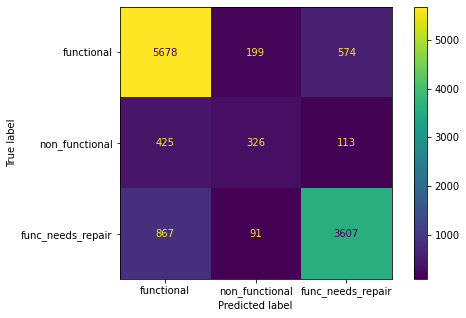

              precision    recall  f1-score   support

           0       0.81      0.88      0.84      6451
           1       0.51      0.36      0.42       864
           2       0.84      0.79      0.81      4565

    accuracy                           0.80     11880
   macro avg       0.72      0.68      0.69     11880
weighted avg       0.80      0.80      0.80     11880



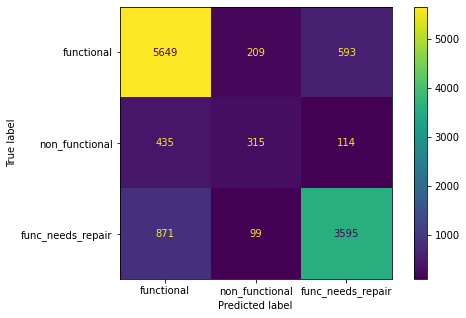

              precision    recall  f1-score   support

           0       0.80      0.90      0.85      6451
           1       0.60      0.31      0.41       864
           2       0.85      0.78      0.81      4565

    accuracy                           0.81     11880
   macro avg       0.75      0.66      0.69     11880
weighted avg       0.80      0.81      0.80     11880



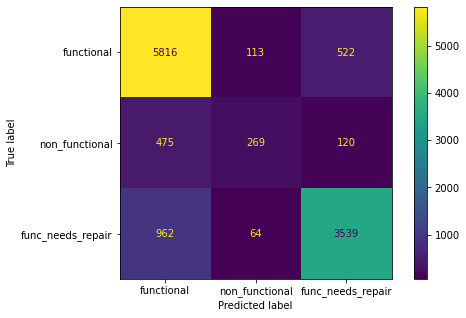

In [662]:

split = 0
mean_acc_rf = 0
mean_acc_lgbm = 0
mean_acc_xgb = 0
mean_acc_ada = 0

for train_index, test_index in rskf.split(X, y):
    
    # Print a dot for each train / test partition
    sys.stdout.write('>>>')
    sys.stdout.flush()
    
    #Test & train split insode the CV
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]

    #Fitting the rare value encoders
    # rare_encoder.fit(X_train)
    rare_encoder_EXtreme_Cardinality.fit(X_train)
    rare_encoder_ExCard_ward.fit(X_train)

    # rare_enc_X_train = rare_encoder.transform(X_train)
    X_train = rare_encoder_EXtreme_Cardinality.transform(X_train)
    X_train = rare_encoder_ExCard_ward.transform(X_train)

    # rare_enc_X_test = rare_encoder.transform(X_test)
    X_test = rare_encoder_EXtreme_Cardinality.transform(X_test)
    X_test = rare_encoder_ExCard_ward.transform(X_test)

    #Fitting the Categorical encoders
    wrapper = PolynomialWrapper(tar_enc)
    X_train = wrapper.fit_transform(X_train, np.array(y_train))
    X_test = wrapper.transform(X_test)
  


##Fitting Models:

# Random Forest
    rf_clf.fit(X_train, y_train)
    y_pred_rf = rf_clf.predict(X_test)
    rf_accuracy = metrics.accuracy_score(y_test, y_pred_rf)
    mean_acc_rf += rf_accuracy
    print(f'rf_Accuracy: {rf_accuracy, split+1}')

# LightGBM
    LightGBM_Clf.fit(X_train, y_train)
    y_pred_LightGBM = LightGBM_Clf.predict(X_test)
    LightGBM_accuracy = metrics.accuracy_score(y_test, y_pred_LightGBM)
    mean_acc_lgbm += LightGBM_accuracy
    print(f'LightGBM_accuracy: {LightGBM_accuracy, split+1}')

#xgboost
    xgboost_clf.fit(X_train, y_train)
    y_pred_xgboost = xgboost_clf.predict(X_test)
    xgboost_accuracy = metrics.accuracy_score(y_test, y_pred_xgboost)
    mean_acc_xgb += xgboost_accuracy
    print(f'xgboost_accuracy: {xgboost_accuracy, split+1}')

#adaboost
    # AdaBoost_clf.fit(X_train, y_train)
    # y_pred_AdaBoost = AdaBoost_clf.predict(X_test)
    # AdaBoostt_accuracy = metrics.accuracy_score(y_test, y_pred_AdaBoost)
    # mean_acc_ada += AdaBoostt_accuracy
    # print(f'AdaBoostt_accuracy: {AdaBoostt_accuracy, split+1}')




    split +=1 

print('Random Forest accuracy is' ,mean_acc_rf/n_splits)
print('Light GBM accuracy is' ,mean_acc_lgbm/n_splits)
print('XGBoost accuracy is' ,mean_acc_xgb/n_splits)
# print('AdaBoosting accuracy is' ,mean_acc_ada/n_splits)


print(classification_report(y_test, y_pred_rf))
# Plot confusion matrix for random Forest
fig, ax = plt.subplots(figsize=(8, 5))
cmp = ConfusionMatrixDisplay(
    confusion_matrix(y_test, y_pred_rf),
    display_labels=["functional", "non_functional", "func_needs_repair"],
)

cmp.plot(ax=ax)
plt.show();


print(classification_report(y_test, y_pred_LightGBM))
# Plot confusion matrix for LightGBM
fig, ax = plt.subplots(figsize=(8, 5))
cmp = ConfusionMatrixDisplay(
    confusion_matrix(y_test, y_pred_LightGBM),
    display_labels=["functional", "non_functional", "func_needs_repair"],
)

cmp.plot(ax=ax)
plt.show();


print(classification_report(y_test, y_pred_xgboost))
# Plot confusion matrix for XGBoost
fig, ax = plt.subplots(figsize=(8, 5))
cmp = ConfusionMatrixDisplay(
    confusion_matrix(y_test, y_pred_xgboost),
    display_labels=["functional", "non_functional", "func_needs_repair"],
)

cmp.plot(ax=ax)
plt.show();


# print(classification_report(y_test, y_pred_AdaBoost))
# # Plot confusion matrix for AdaBoost
# fig, ax = plt.subplots(figsize=(8, 5))
# cmp = ConfusionMatrixDisplay(
#     confusion_matrix(y_test, y_pred_AdaBoost),
#     display_labels=["functional", "non_functional", "func_needs_repair"],
# )

# cmp.plot(ax=ax)
# plt.show();

#5.2 Feature Engineering and Modeling within Cross Validation - CatBoost Encoding

In [663]:
# Use the results of any categorical encoding that you chose

train = cb_train.copy()
test = cb_test.copy()

In [664]:
X = train.drop('status_group',axis=1)
y = train.status_group

In [665]:
n_repeats =1
n_splits = 5
rskf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats = n_repeats, random_state=0)

>>>rf_Accuracy: (0.7882996632996633, 1)
LightGBM_accuracy: (0.7843434343434343, 1)
xgboost_accuracy: (0.7870370370370371, 1)
>>>rf_Accuracy: (0.7888888888888889, 2)
LightGBM_accuracy: (0.7895622895622896, 2)
xgboost_accuracy: (0.7897306397306397, 2)
>>>rf_Accuracy: (0.7940235690235691, 3)
LightGBM_accuracy: (0.7930976430976431, 3)
xgboost_accuracy: (0.796043771043771, 3)
>>>rf_Accuracy: (0.786952861952862, 4)
LightGBM_accuracy: (0.7926767676767676, 4)
xgboost_accuracy: (0.7839225589225589, 4)
>>>rf_Accuracy: (0.7894781144781144, 5)
LightGBM_accuracy: (0.7906565656565656, 5)
xgboost_accuracy: (0.7877946127946128, 5)
Random Forest accuracy is 0.7895286195286195
Light GBM accuracy is 0.7900673400673399
XGBoost accuracy is 0.7889057239057239
              precision    recall  f1-score   support

           0       0.77      0.92      0.83      6451
           1       0.69      0.22      0.33       864
           2       0.84      0.72      0.78      4565

    accuracy                      

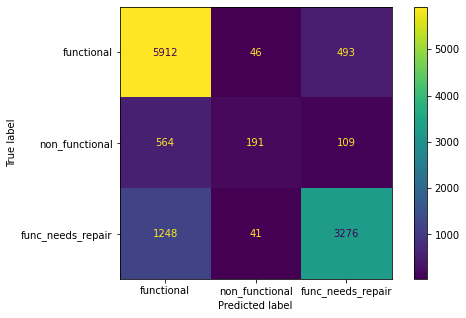

              precision    recall  f1-score   support

           0       0.77      0.91      0.83      6451
           1       0.71      0.20      0.32       864
           2       0.83      0.74      0.78      4565

    accuracy                           0.79     11880
   macro avg       0.77      0.62      0.64     11880
weighted avg       0.79      0.79      0.78     11880



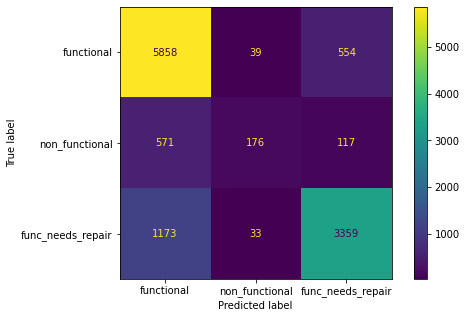

              precision    recall  f1-score   support

           0       0.76      0.92      0.83      6451
           1       0.72      0.18      0.29       864
           2       0.85      0.71      0.77      4565

    accuracy                           0.79     11880
   macro avg       0.78      0.61      0.63     11880
weighted avg       0.79      0.79      0.77     11880



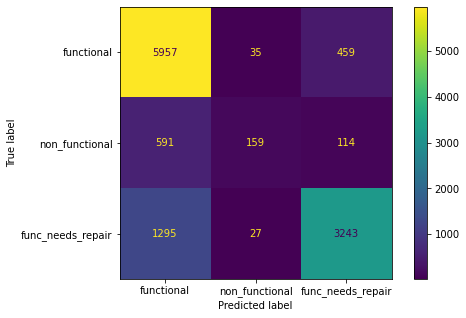

In [666]:

split = 0
mean_acc_rf = 0
mean_acc_lgbm = 0
mean_acc_xgb = 0
mean_acc_ada = 0

for train_index, test_index in rskf.split(X, y):
    
    # Print a dot for each train / test partition
    sys.stdout.write('>>>')
    sys.stdout.flush()
    
    #Test & train split insode the CV
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]

    #Fitting the rare value encoders
    # rare_encoder.fit(X_train)
    rare_encoder_EXtreme_Cardinality.fit(X_train)
    rare_encoder_ExCard_ward.fit(X_train)

    # X_train = rare_encoder.transform(X_train)
    X_train = rare_encoder_EXtreme_Cardinality.transform(X_train)
    X_train = rare_encoder_ExCard_ward.transform(X_train)

    # X_test = rare_encoder.transform(X_test)
    X_test = rare_encoder_EXtreme_Cardinality.transform(X_test)
    X_test = rare_encoder_ExCard_ward.transform(X_test)

    #Fitting the Categorical encoders
    wrapper = PolynomialWrapper(cb_enc)
    X_train = wrapper.fit_transform(X_train, np.array(y_train))
    X_test = wrapper.transform(X_test)


##Fitting Models:

# Random Forest
    rf_clf.fit(X_train, y_train)
    y_pred_rf = rf_clf.predict(X_test)
    rf_accuracy = metrics.accuracy_score(y_test, y_pred_rf)
    mean_acc_rf += rf_accuracy
    print(f'rf_Accuracy: {rf_accuracy, split+1}')

# LightGBM
    LightGBM_Clf.fit(X_train, y_train)
    y_pred_LightGBM = LightGBM_Clf.predict(X_test)
    LightGBM_accuracy = metrics.accuracy_score(y_test, y_pred_LightGBM)
    mean_acc_lgbm += LightGBM_accuracy
    print(f'LightGBM_accuracy: {LightGBM_accuracy, split+1}')

#xgboost
    xgboost_clf.fit(X_train, y_train)
    y_pred_xgboost = xgboost_clf.predict(X_test)
    xgboost_accuracy = metrics.accuracy_score(y_test, y_pred_xgboost)
    mean_acc_xgb += xgboost_accuracy
    print(f'xgboost_accuracy: {xgboost_accuracy, split+1}')

#adaboost
    # AdaBoost_clf.fit(X_train, y_train)
    # y_pred_rf = rf_clf.predict(X_test)
    # AdaBoostt_accuracy = metrics.accuracy_score(y_test, y_pred_rf)
    # mean_acc_ada += AdaBoostt_accuracy
    # print(f'AdaBoostt_accuracy: {AdaBoostt_accuracy, split+1}')

    split +=1 

print('Random Forest accuracy is' ,mean_acc_rf/n_splits)
print('Light GBM accuracy is' ,mean_acc_lgbm/n_splits)
print('XGBoost accuracy is' ,mean_acc_xgb/n_splits)
# print('AdaBoosting accuracy is' ,mean_acc_ada/n_splits)


print(classification_report(y_test, y_pred_rf))
# Plot confusion matrix for random Forest
fig, ax = plt.subplots(figsize=(8, 5))
cmp = ConfusionMatrixDisplay(
    confusion_matrix(y_test, y_pred_rf),
    display_labels=["functional", "non_functional", "func_needs_repair"],
)

cmp.plot(ax=ax)
plt.show();


print(classification_report(y_test, y_pred_LightGBM))
# Plot confusion matrix for LightGBM
fig, ax = plt.subplots(figsize=(8, 5))
cmp = ConfusionMatrixDisplay(
    confusion_matrix(y_test, y_pred_LightGBM),
    display_labels=["functional", "non_functional", "func_needs_repair"],
)

cmp.plot(ax=ax)
plt.show();


print(classification_report(y_test, y_pred_xgboost))
# Plot confusion matrix for XGBoost
fig, ax = plt.subplots(figsize=(8, 5))
cmp = ConfusionMatrixDisplay(
    confusion_matrix(y_test, y_pred_xgboost),
    display_labels=["functional", "non_functional", "func_needs_repair"],
)

cmp.plot(ax=ax)
plt.show();


# print(classification_report(y_test, y_pred_AdaBoost))
# # Plot confusion matrix for AdaBoost
# fig, ax = plt.subplots(figsize=(8, 5))
# cmp = ConfusionMatrixDisplay(
#     confusion_matrix(y_test, y_pred_AdaBoost),
#     display_labels=["functional", "non_functional", "func_needs_repair"],
# )

# cmp.plot(ax=ax)
# plt.show();

#5.4 Feature Engineering and Modeling within Cross Validation - LeaveOneOut Encoding

In [667]:
# Use the results of any categorical encoding that you chose

train = loo_train.copy()
test = loo_test.copy()

In [668]:
X = train.drop('status_group',axis=1)
y = train.status_group

In [669]:
n_repeats =1
n_splits = 5
rskf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats = n_repeats, random_state=0)

>>>rf_Accuracy: (0.5476430976430976, 1)
LightGBM_accuracy: (0.5458754208754208, 1)
xgboost_accuracy: (0.5541245791245791, 1)
>>>rf_Accuracy: (0.5492424242424242, 2)
LightGBM_accuracy: (0.546043771043771, 2)
xgboost_accuracy: (0.5512626262626262, 2)
>>>rf_Accuracy: (0.5489057239057239, 3)
LightGBM_accuracy: (0.5484848484848485, 3)
xgboost_accuracy: (0.5537037037037037, 3)
>>>rf_Accuracy: (0.5505892255892256, 4)
LightGBM_accuracy: (0.546043771043771, 4)
xgboost_accuracy: (0.553956228956229, 4)
>>>rf_Accuracy: (0.548989898989899, 5)
LightGBM_accuracy: (0.546969696969697, 5)
xgboost_accuracy: (0.5527777777777778, 5)
Random Forest accuracy is 0.549074074074074
Light GBM accuracy is 0.5466835016835017
XGBoost accuracy is 0.5531649831649832
              precision    recall  f1-score   support

           0       0.55      1.00      0.71      6451
           1       0.00      0.00      0.00       864
           2       0.85      0.02      0.04      4565

    accuracy                          

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


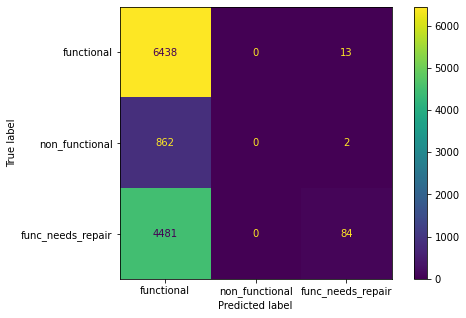

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.55      1.00      0.71      6451
           1       0.00      0.00      0.00       864
           2       0.75      0.01      0.03      4565

    accuracy                           0.55     11880
   macro avg       0.43      0.34      0.24     11880
weighted avg       0.59      0.55      0.39     11880



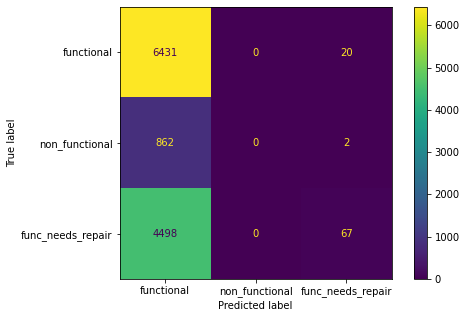

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.55      1.00      0.71      6451
           1       0.00      0.00      0.00       864
           2       0.95      0.03      0.05      4565

    accuracy                           0.55     11880
   macro avg       0.50      0.34      0.25     11880
weighted avg       0.66      0.55      0.40     11880



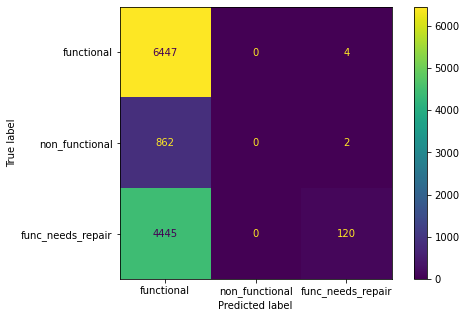

In [670]:

split = 0
mean_acc_rf = 0
mean_acc_lgbm = 0
mean_acc_xgb = 0
mean_acc_ada = 0

for train_index, test_index in rskf.split(X, y):
    
    # Print a dot for each train / test partition
    sys.stdout.write('>>>')
    sys.stdout.flush()
    
    #Test & train split insode the CV
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]

    #Fitting the rare value encoders
    # rare_encoder.fit(X_test)
    rare_encoder_EXtreme_Cardinality.fit(X_train)
    rare_encoder_ExCard_ward.fit(X_train)

    # X_test = rare_encoder.transform(X_train)
    X_test = rare_encoder_EXtreme_Cardinality.transform(X_test)
    X_test = rare_encoder_ExCard_ward.transform(X_test)

    # X_test = rare_encoder.transform(X_test)
    X_test = rare_encoder_EXtreme_Cardinality.transform(X_test)
    X_test = rare_encoder_ExCard_ward.transform(X_test)

    #Fitting the Categorical encoders
    wrapper = PolynomialWrapper(loo_enc)
    X_train = wrapper.fit_transform(X_train, np.array(y_train))
    X_test = wrapper.transform(X_test)


##Fitting Models:

# Random Forest
    rf_clf.fit(X_train, y_train)
    y_pred_rf = rf_clf.predict(X_test)
    rf_accuracy = metrics.accuracy_score(y_test, y_pred_rf)
    mean_acc_rf += rf_accuracy
    print(f'rf_Accuracy: {rf_accuracy, split+1}')

# LightGBM
    LightGBM_Clf.fit(X_train, y_train)
    y_pred_LightGBM = LightGBM_Clf.predict(X_test)
    LightGBM_accuracy = metrics.accuracy_score(y_test, y_pred_LightGBM)
    mean_acc_lgbm += LightGBM_accuracy
    print(f'LightGBM_accuracy: {LightGBM_accuracy, split+1}')

#xgboost
    xgboost_clf.fit(X_train, y_train)
    y_pred_xgboost = xgboost_clf.predict(X_test)
    xgboost_accuracy = metrics.accuracy_score(y_test, y_pred_xgboost)
    mean_acc_xgb += xgboost_accuracy
    print(f'xgboost_accuracy: {xgboost_accuracy, split+1}')

#adaboost
    # AdaBoost_clf.fit(X_train, y_train)
    # y_pred_rf = rf_clf.predict(X_test)
    # AdaBoostt_accuracy = metrics.accuracy_score(y_test, y_pred_rf)
    # mean_acc_ada += AdaBoostt_accuracy
    # print(f'AdaBoostt_accuracy: {AdaBoostt_accuracy, split+1}')

    split +=1 

print('Random Forest accuracy is' ,mean_acc_rf/n_splits)
print('Light GBM accuracy is' ,mean_acc_lgbm/n_splits)
print('XGBoost accuracy is' ,mean_acc_xgb/n_splits)
# print('AdaBoosting accuracy is' ,mean_acc_ada/n_splits)



print(classification_report(y_test, y_pred_rf))
# Plot confusion matrix for random Forest
fig, ax = plt.subplots(figsize=(8, 5))
cmp = ConfusionMatrixDisplay(
    confusion_matrix(y_test, y_pred_rf),
    display_labels=["functional", "non_functional", "func_needs_repair"],
)

cmp.plot(ax=ax)
plt.show();


print(classification_report(y_test, y_pred_LightGBM))
# Plot confusion matrix for LightGBM
fig, ax = plt.subplots(figsize=(8, 5))
cmp = ConfusionMatrixDisplay(
    confusion_matrix(y_test, y_pred_LightGBM),
    display_labels=["functional", "non_functional", "func_needs_repair"],
)

cmp.plot(ax=ax)
plt.show();


print(classification_report(y_test, y_pred_xgboost))
# Plot confusion matrix for XGBoost
fig, ax = plt.subplots(figsize=(8, 5))
cmp = ConfusionMatrixDisplay(
    confusion_matrix(y_test, y_pred_xgboost),
    display_labels=["functional", "non_functional", "func_needs_repair"],
)

cmp.plot(ax=ax)
plt.show();


# print(classification_report(y_test, y_pred_AdaBoost))
# # Plot confusion matrix for AdaBoost
# fig, ax = plt.subplots(figsize=(8, 5))
# cmp = ConfusionMatrixDisplay(
#     confusion_matrix(y_test, y_pred_AdaBoost),
#     display_labels=["functional", "non_functional", "func_needs_repair"],
# )

# cmp.plot(ax=ax)
# plt.show();

#5.5 Feature Engineering and Modeling within Cross Validation - MEstimate Encoding

In [671]:
# Use the results of any categorical encoding that you chose

train = loo_train.copy()
test = loo_test.copy()

In [672]:
X = train.drop('status_group',axis=1)
y = train.status_group

In [673]:
n_repeats =1
n_splits = 5
rskf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats = n_repeats, random_state=0)

>>>rf_Accuracy: (0.80993265993266, 1)
LightGBM_accuracy: (0.8041245791245791, 1)
xgboost_accuracy: (0.8128787878787879, 1)
>>>rf_Accuracy: (0.8042929292929293, 2)
LightGBM_accuracy: (0.8015993265993266, 2)
xgboost_accuracy: (0.8092592592592592, 2)
>>>rf_Accuracy: (0.8101010101010101, 3)
LightGBM_accuracy: (0.8053030303030303, 3)
xgboost_accuracy: (0.8133838383838384, 3)
>>>rf_Accuracy: (0.80993265993266, 4)
LightGBM_accuracy: (0.8045454545454546, 4)
xgboost_accuracy: (0.8106902356902357, 4)
>>>rf_Accuracy: (0.8101010101010101, 5)
LightGBM_accuracy: (0.8067340067340067, 5)
xgboost_accuracy: (0.8142255892255892, 5)
Random Forest accuracy is 0.8088720538720539
Light GBM accuracy is 0.8044612794612795
XGBoost accuracy is 0.8120875420875422
              precision    recall  f1-score   support

           0       0.81      0.89      0.85      6451
           1       0.55      0.37      0.44       864
           2       0.84      0.79      0.81      4565

    accuracy                        

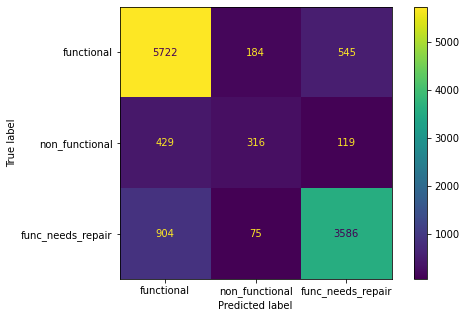

              precision    recall  f1-score   support

           0       0.81      0.88      0.85      6451
           1       0.53      0.35      0.42       864
           2       0.83      0.79      0.81      4565

    accuracy                           0.81     11880
   macro avg       0.73      0.67      0.69     11880
weighted avg       0.80      0.81      0.80     11880



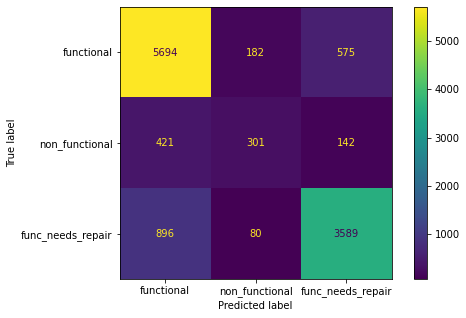

              precision    recall  f1-score   support

           0       0.80      0.91      0.85      6451
           1       0.65      0.32      0.43       864
           2       0.85      0.77      0.81      4565

    accuracy                           0.81     11880
   macro avg       0.77      0.67      0.70     11880
weighted avg       0.81      0.81      0.81     11880



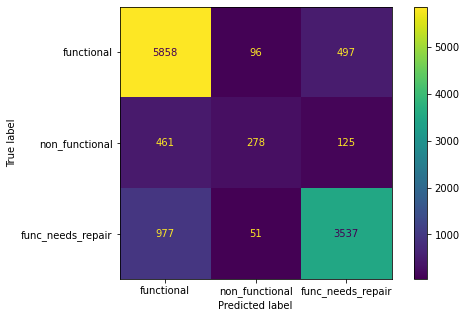

In [674]:

split = 0
mean_acc_rf = 0
mean_acc_lgbm = 0
mean_acc_xgb = 0
mean_acc_ada = 0

for train_index, test_index in rskf.split(X, y):
    
    # Print a dot for each train / test partition
    sys.stdout.write('>>>')
    sys.stdout.flush()
    
    #Test & train split insode the CV
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]

    #Fitting the rare value encoders
    # rare_encoder.fit(X_train)
    rare_encoder_EXtreme_Cardinality.fit(X_train)
    rare_encoder_ExCard_ward.fit(X_train)

    # X_train = rare_encoder.transform(X_train)
    X_train = rare_encoder_EXtreme_Cardinality.transform(X_train)
    X_train = rare_encoder_ExCard_ward.transform(X_train)

    # X_test = rare_encoder.transform(X_test)
    X_test = rare_encoder_EXtreme_Cardinality.transform(X_test)
    X_test = rare_encoder_ExCard_ward.transform(X_test)

    #Fitting the Categorical encoders
    wrapper = PolynomialWrapper(me_enc)
    X_train = wrapper.fit_transform(X_train, np.array(y_train))
    X_test = wrapper.transform(X_test)


##Fitting Models:

# Random Forest
    rf_clf.fit(X_train, y_train)
    y_pred_rf = rf_clf.predict(X_test)
    rf_accuracy = metrics.accuracy_score(y_test, y_pred_rf)
    mean_acc_rf += rf_accuracy
    print(f'rf_Accuracy: {rf_accuracy, split+1}')

# LightGBM
    LightGBM_Clf.fit(X_train, y_train)
    y_pred_LightGBM = LightGBM_Clf.predict(X_test)
    LightGBM_accuracy = metrics.accuracy_score(y_test, y_pred_LightGBM)
    mean_acc_lgbm += LightGBM_accuracy
    print(f'LightGBM_accuracy: {LightGBM_accuracy, split+1}')

#xgboost
    xgboost_clf.fit(X_train, y_train)
    y_pred_xgboost = xgboost_clf.predict(X_test)
    xgboost_accuracy = metrics.accuracy_score(y_test, y_pred_xgboost)
    mean_acc_xgb += xgboost_accuracy
    print(f'xgboost_accuracy: {xgboost_accuracy, split+1}')

#adaboost
    # AdaBoost_clf.fit(X_train, y_train)
    # y_pred_rf = rf_clf.predict(X_test)
    # AdaBoostt_accuracy = metrics.accuracy_score(y_test, y_pred_rf)
    # mean_acc_ada += AdaBoostt_accuracy
    # print(f'AdaBoostt_accuracy: {AdaBoostt_accuracy, split+1}')

    split +=1 

print('Random Forest accuracy is' ,mean_acc_rf/n_splits)
print('Light GBM accuracy is' ,mean_acc_lgbm/n_splits)
print('XGBoost accuracy is' ,mean_acc_xgb/n_splits)
# print('AdaBoosting accuracy is' ,mean_acc_ada/n_splits)


print(classification_report(y_test, y_pred_rf))
# Plot confusion matrix for random Forest
fig, ax = plt.subplots(figsize=(8, 5))
cmp = ConfusionMatrixDisplay(
    confusion_matrix(y_test, y_pred_rf),
    display_labels=["functional", "non_functional", "func_needs_repair"],
)

cmp.plot(ax=ax)
plt.show();


print(classification_report(y_test, y_pred_LightGBM))
# Plot confusion matrix for LightGBM
fig, ax = plt.subplots(figsize=(8, 5))
cmp = ConfusionMatrixDisplay(
    confusion_matrix(y_test, y_pred_LightGBM),
    display_labels=["functional", "non_functional", "func_needs_repair"],
)

cmp.plot(ax=ax)
plt.show();


print(classification_report(y_test, y_pred_xgboost))
# Plot confusion matrix for XGBoost
fig, ax = plt.subplots(figsize=(8, 5))
cmp = ConfusionMatrixDisplay(
    confusion_matrix(y_test, y_pred_xgboost),
    display_labels=["functional", "non_functional", "func_needs_repair"],
)

cmp.plot(ax=ax)
plt.show();


# print(classification_report(y_test, y_pred_AdaBoost))
# # Plot confusion matrix for AdaBoost
# fig, ax = plt.subplots(figsize=(8, 5))
# cmp = ConfusionMatrixDisplay(
#     confusion_matrix(y_test, y_pred_AdaBoost),
#     display_labels=["functional", "non_functional", "func_needs_repair"],
# )

# cmp.plot(ax=ax)
# plt.show();

#5.5 Feature Engineering and Modeling within Cross Validation - James-Stein Encoding

In [675]:
# Use the results of any categorical encoding that you chose

train = js_train.copy()
test = js_test.copy()

In [676]:
X = train.drop('status_group',axis=1)
y = train.status_group

In [677]:
n_repeats =1
n_splits = 5
rskf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats = n_repeats, random_state=0)

>>>rf_Accuracy: (0.8084175084175084, 1)
LightGBM_accuracy: (0.8052188552188552, 1)
xgboost_accuracy: (0.8132154882154882, 1)
>>>rf_Accuracy: (0.8041245791245791, 2)
LightGBM_accuracy: (0.8015993265993266, 2)
xgboost_accuracy: (0.8082491582491582, 2)
>>>rf_Accuracy: (0.8094276094276094, 3)
LightGBM_accuracy: (0.8042087542087543, 3)
xgboost_accuracy: (0.814057239057239, 3)
>>>rf_Accuracy: (0.8085016835016835, 4)
LightGBM_accuracy: (0.8045454545454546, 4)
xgboost_accuracy: (0.8102693602693603, 4)
>>>rf_Accuracy: (0.810016835016835, 5)
LightGBM_accuracy: (0.8057239057239057, 5)
xgboost_accuracy: (0.8133838383838384, 5)
Random Forest accuracy is 0.8080976430976431
Light GBM accuracy is 0.8042592592592592
XGBoost accuracy is 0.8118350168350169
              precision    recall  f1-score   support

           0       0.81      0.89      0.85      6451
           1       0.55      0.37      0.44       864
           2       0.84      0.79      0.81      4565

    accuracy                      

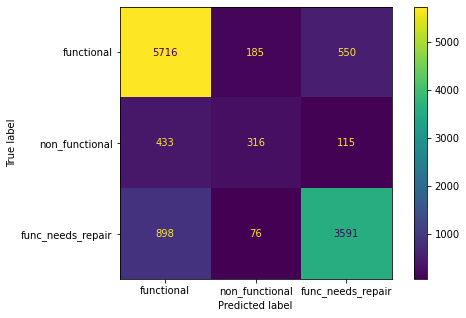

              precision    recall  f1-score   support

           0       0.81      0.88      0.84      6451
           1       0.53      0.36      0.42       864
           2       0.83      0.79      0.81      4565

    accuracy                           0.81     11880
   macro avg       0.72      0.67      0.69     11880
weighted avg       0.80      0.81      0.80     11880



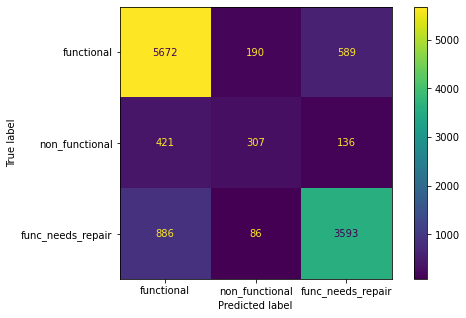

              precision    recall  f1-score   support

           0       0.80      0.91      0.85      6451
           1       0.62      0.32      0.43       864
           2       0.85      0.78      0.81      4565

    accuracy                           0.81     11880
   macro avg       0.76      0.67      0.70     11880
weighted avg       0.81      0.81      0.81     11880



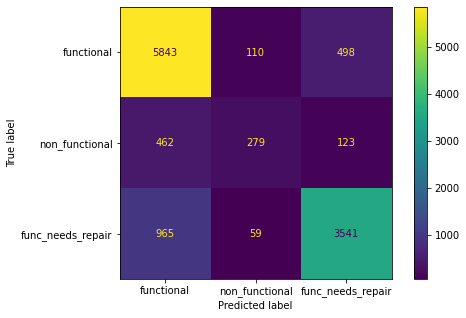

In [678]:

split = 0
mean_acc_rf = 0
mean_acc_lgbm = 0
mean_acc_xgb = 0
mean_acc_ada = 0

for train_index, test_index in rskf.split(X, y):
    
    # Print a dot for each train / test partition
    sys.stdout.write('>>>')
    sys.stdout.flush()
    
    #Test & train split insode the CV
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]

    #Fitting the rare value encoders
    # rare_encoder.fit(X_train)
    rare_encoder_EXtreme_Cardinality.fit(X_train)
    rare_encoder_ExCard_ward.fit(X_train)

    # X_train = rare_encoder.transform(X_train)
    X_train = rare_encoder_EXtreme_Cardinality.transform(X_train)
    X_train = rare_encoder_ExCard_ward.transform(X_train)

    # X_test = rare_encoder.transform(X_test)
    X_test = rare_encoder_EXtreme_Cardinality.transform(X_test)
    X_test = rare_encoder_ExCard_ward.transform(X_test)

    #Fitting the Categorical encoders
    wrapper = PolynomialWrapper(js_enc)
    X_train = wrapper.fit_transform(X_train, np.array(y_train))
    X_test = wrapper.transform(X_test)


##Fitting Models:

# Random Forest
    rf_clf.fit(X_train, y_train)
    y_pred_rf = rf_clf.predict(X_test)
    rf_accuracy = metrics.accuracy_score(y_test, y_pred_rf)
    mean_acc_rf += rf_accuracy
    print(f'rf_Accuracy: {rf_accuracy, split+1}')

# LightGBM
    LightGBM_Clf.fit(X_train, y_train)
    y_pred_LightGBM = LightGBM_Clf.predict(X_test)
    LightGBM_accuracy = metrics.accuracy_score(y_test, y_pred_LightGBM)
    mean_acc_lgbm += LightGBM_accuracy
    print(f'LightGBM_accuracy: {LightGBM_accuracy, split+1}')

#xgboost
    xgboost_clf.fit(X_train, y_train)
    y_pred_xgboost = xgboost_clf.predict(X_test)
    xgboost_accuracy = metrics.accuracy_score(y_test, y_pred_xgboost)
    mean_acc_xgb += xgboost_accuracy
    print(f'xgboost_accuracy: {xgboost_accuracy, split+1}')

#adaboost
    # AdaBoost_clf.fit(X_train, y_train)
    # y_pred_rf = rf_clf.predict(X_test)
    # AdaBoostt_accuracy = metrics.accuracy_score(y_test, y_pred_rf)
    # mean_acc_ada += AdaBoostt_accuracy
    # print(f'AdaBoostt_accuracy: {AdaBoostt_accuracy, split+1}')

    split +=1 

print('Random Forest accuracy is' ,mean_acc_rf/n_splits)
print('Light GBM accuracy is' ,mean_acc_lgbm/n_splits)
print('XGBoost accuracy is' ,mean_acc_xgb/n_splits)
# print('AdaBoosting accuracy is' ,mean_acc_ada/n_splits)



print(classification_report(y_test, y_pred_rf))
# Plot confusion matrix for random Forest
fig, ax = plt.subplots(figsize=(8, 5))
cmp = ConfusionMatrixDisplay(
    confusion_matrix(y_test, y_pred_rf),
    display_labels=["functional", "non_functional", "func_needs_repair"],
)

cmp.plot(ax=ax)
plt.show();


print(classification_report(y_test, y_pred_LightGBM))
# Plot confusion matrix for LightGBM
fig, ax = plt.subplots(figsize=(8, 5))
cmp = ConfusionMatrixDisplay(
    confusion_matrix(y_test, y_pred_LightGBM),
    display_labels=["functional", "non_functional", "func_needs_repair"],
)

cmp.plot(ax=ax)
plt.show();


print(classification_report(y_test, y_pred_xgboost))
# Plot confusion matrix for XGBoost
fig, ax = plt.subplots(figsize=(8, 5))
cmp = ConfusionMatrixDisplay(
    confusion_matrix(y_test, y_pred_xgboost),
    display_labels=["functional", "non_functional", "func_needs_repair"],
)

cmp.plot(ax=ax)
plt.show();


# print(classification_report(y_test, y_pred_AdaBoost))
# # Plot confusion matrix for AdaBoost
# fig, ax = plt.subplots(figsize=(8, 5))
# cmp = ConfusionMatrixDisplay(
#     confusion_matrix(y_test, y_pred_AdaBoost),
#     display_labels=["functional", "non_functional", "func_needs_repair"],
# )

# cmp.plot(ax=ax)
# plt.show();